# Project 3: Poisonous mushrooms
In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [54]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

from sklearn.mixture import GaussianMixture


Load feature names.

In [18]:
feature_names = []
with open('C:\\Users\\I822363\\Documents\\W207\\Data\\mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Loaded feature names: 126
Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [19]:
X, Y = [], []

with open('C:\\Users\\I822363\\Documents\\W207\\Data\\mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


Convert to Data Frames

In [20]:
X_train = pd.DataFrame(data = train_data)
y_train = pd.DataFrame(train_labels)

X_test = pd.DataFrame(data = test_data)
y_test = pd.DataFrame(data = test_labels)

(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

50 principal components are able to explain 98.21 percent of the variance
k: 2 components explain 16.40 percent of the variance
k: 3 components explain 29.73 percent of the variance
k: 4 components explain 39.90 percent of the variance
k: 5 components explain 46.96 percent of the variance
k: 6 components explain 50.83 percent of the variance
k: 7 components explain 54.51 percent of the variance
k: 8 components explain 57.64 percent of the variance
k: 9 components explain 60.37 percent of the variance
k: 10 components explain 62.99 percent of the variance
k: 11 components explain 65.22 percent of the variance
k: 12 components explain 67.27 percent of the variance
k: 13 components explain 69.14 percent of the variance
k: 14 components explain 70.87 percent of the variance
k: 15 components explain 72.56 percent of the variance
k: 16 components explain 74.08 percent of the variance
k: 17 components explain 75.58 percent of the variance
k: 18 components explain 77.01 percent of the variance

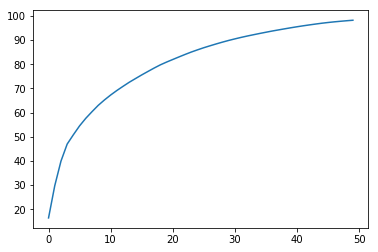

In [21]:
def P1(ip_num_comp = 50):
    pca = PCA(n_components= ip_num_comp)
    pca.fit(X_train)
    print('50 principal components are able to explain %.2f percent of the variance' % (
        np.round(np.sum(pca.explained_variance_ratio_),4) * 100))
    for i in range(1, ip_num_comp + 1):
        cum_var = 100 * np.sum(pca.explained_variance_ratio_[:i])
        print('k: %d components explain %.2f percent of the variance' % (i+1, np.round(cum_var,4)))
    plt.plot(100 * np.cumsum(pca.explained_variance_ratio_))
    return pca
    
pca = P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

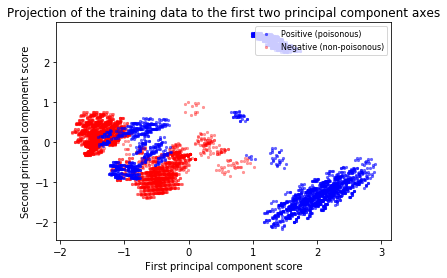

In [22]:
def P2(ip_num_comp = 2):
# Method 3 to carry out PCA 
# from the previously calculated PCA, pick only 2 components
# and separate them into poisonous and non posinous based on labels
# and chart them
    Vt = pca.components_[:2, :]
    M = X_train - X_train.mean()
    U = np.matmul(M, np.transpose(Vt))
    
    # segregate into poisonous and non-poisonous
    poison_data = U[y_train.index[y_train[0] == 1].tolist(), :]
    non_poison_data = U[y_train.index[y_train[0] == 0].tolist(), :]
    
    # Begin plotting
    non_poison = plt.scatter(
        non_poison_data[:,0], non_poison_data[:,1],facecolor='r',marker="o",alpha=.4,s=8,lw=0.3)
    poison = plt.scatter(
        poison_data[:,0],poison_data[:,1],facecolor='b',marker="o",alpha=.6,s=8,lw=0.3)
    plt.xlabel("First principal component score")
    plt.ylabel('Second principal component score')
    plt.title("Projection of the training data to the first two principal component axes")
    plt.legend((poison,non_poison),
           ('Positive (poisonous)', 'Negative (non-poisonous)'),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=8)
    plt.show() 

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

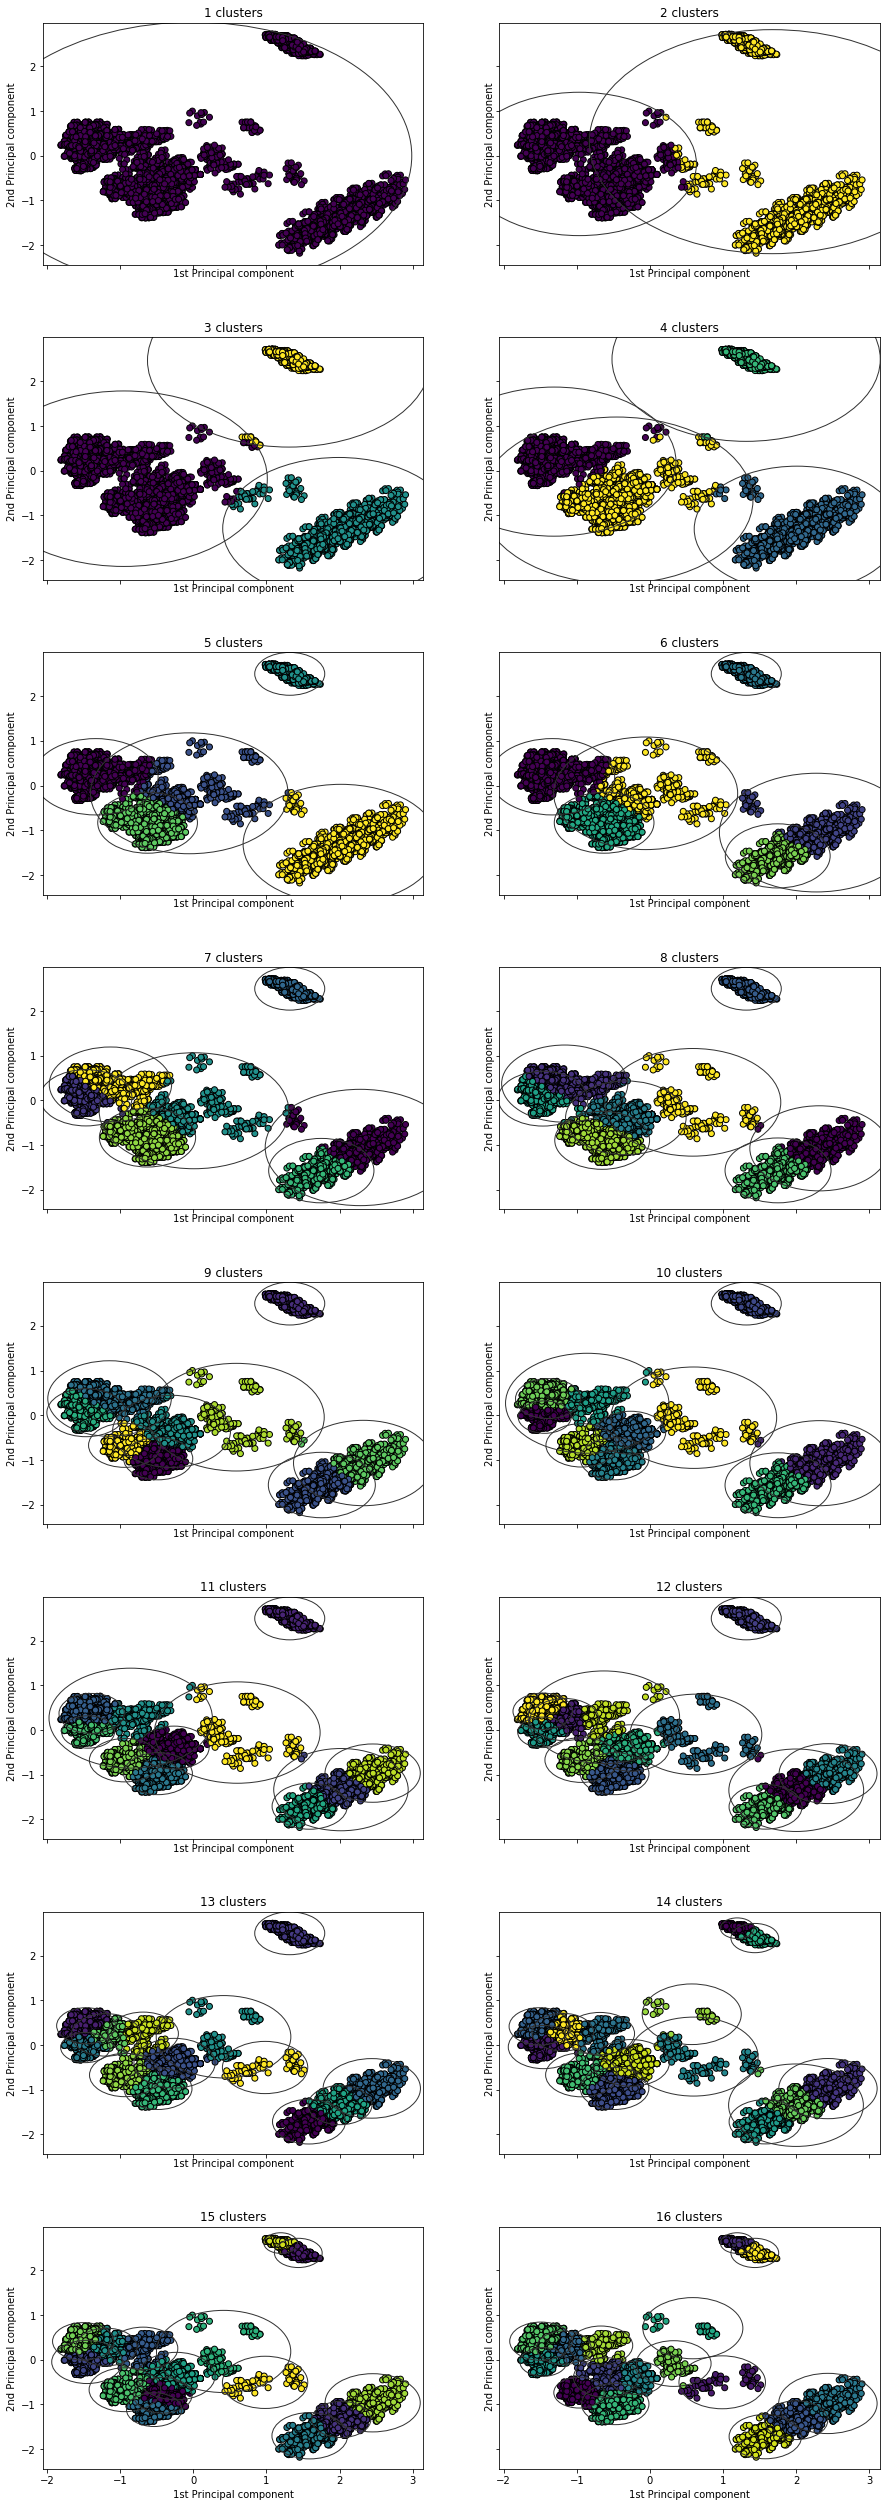

In [23]:
def P3():
    f, axarr = plt.subplots(8, 2, figsize=(15,45))
    f.subplots_adjust(hspace=0.3)

    n_clusters = 0
    for i in range(8):
        for j in range(2):
            n_clusters += 1
            km = KMeans(n_clusters=n_clusters)
            km.fit(X_reduced)
            axarr[i, j].scatter(X_reduced[:, 0], X_reduced[:, 1], c=km.labels_, edgecolor='black')
            axarr[i, j].set_title('%d clusters' % (n_clusters))
            for cc in range(km.cluster_centers_.shape[0]):
                dists = km.transform(X_reduced[km.labels_ == cc])
                radii = np.amax(dists, axis=0)[cc]
                circ = plt.Circle((km.cluster_centers_[cc]), radius = radii, fill=False, ec='0.2')
                ax = axarr[i, j]
                ax.add_patch(circ)
        
    for idx, ax in enumerate(axarr.flat):
        ax.set(xlabel='1st Principal component', ylabel='2nd Principal component')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axarr.flat:
        ax.label_outer()

X_reduced = PCA(n_components = 2).fit_transform(X_train)        
P3()

In [69]:
X_reduced[y_train.index[y_train[0] == 1].tolist(), :]

array([[-1.05434457, -0.89426312],
       [-1.18360338, -0.59804217],
       [-0.92105755, -0.5139045 ],
       ..., 
       [-0.98473449, -0.82398795],
       [-0.99737903, -0.67719089],
       [-0.84782644, -0.52479507]])

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full')

C:\Users\I822363\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


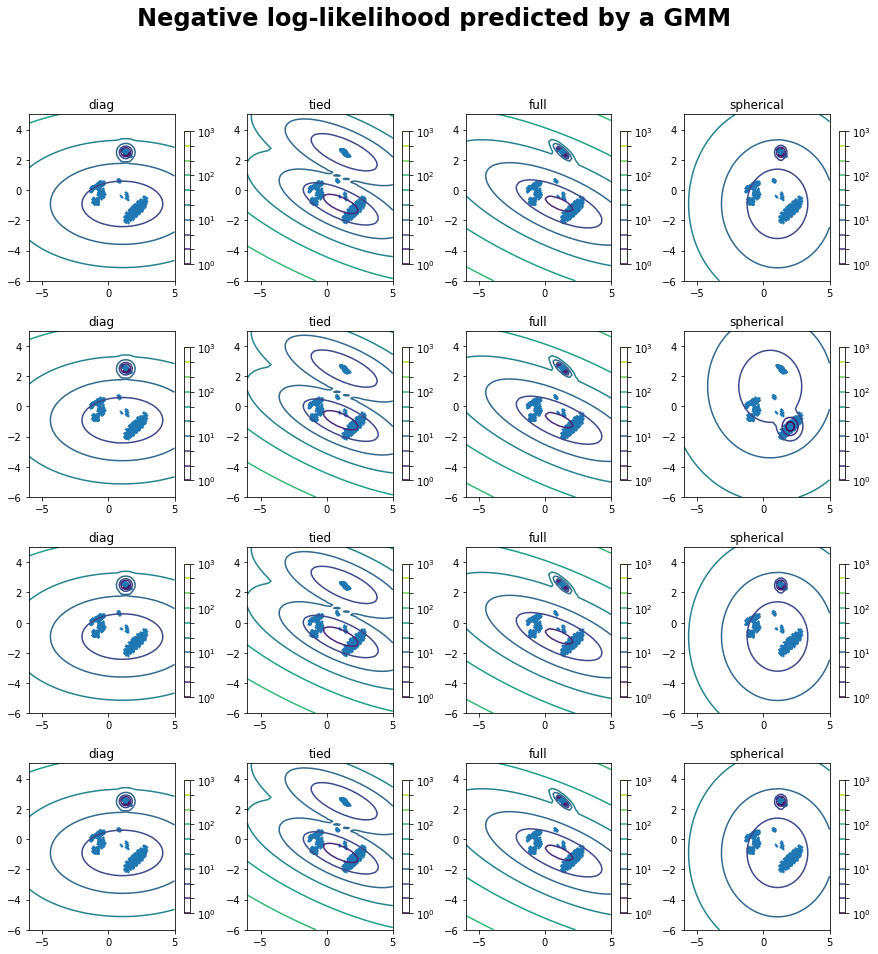

In [114]:
def P4():
    n_samples = 300
    f, axarr = plt.subplots(4, 4, figsize=(15,15))
    f.subplots_adjust(hspace=0.3)
    n_comps = 0
    categories = ['spherical', 'diag', 'tied', 'full']

    #Initialize variables for contour plot
    x = np.linspace(-6., 5.)
    y = np.linspace(-6., 5.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T

    # Filter and select only the poisonous mushrooms
    X_train_poisonous = X_reduced[y_train.index[y_train[0] == 1].tolist(), :]
    
    #Plot the graphs for upto 4 components
    for i in range(1,17):
        if i % 4 == 1:
            n_comps += 1
        cat = categories[i % 4]
            # fit a Gaussian Mixture Model with two components
        sub1 = plt.subplot(4,4,i)
        gm_mod = GaussianMixture(
                  n_components = comps, 
                covariance_type=cat
                )
        gm_mod.fit(X_train_poisonous)
            # display predicted scores by the model as a contour plot
        Z = -gm_mod.score_samples(XX)
        Z = Z.reshape(X.shape)
        CS = plt.contour(
                 X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
        CB = plt.colorbar(CS, shrink=0.8, extend='both')
        plt.scatter(X_train_poisonous[:, 0], X_train_poisonous[:, 1], .8)
        plt.title(cat)
    
    plt.axis('tight')    
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axarr.flat:
        ax.label_outer()
    f.suptitle('Negative log-likelihood predicted by a GMM', fontsize = 24, fontweight = 'bold')
        
            
P4()

Object `ax.scatter` not found.


In [ ]:
axarr[i,j].scatter